# Exercise 4.1: Sarcasm Detection

Way back in Exercise 1.1, you trained a text classifier for an NLP problem that was mostly objective: _nationality classification._ You likely attained pretty high performance too! In that task, there was ample evidence of the class in the data itself that made it easier to determine the right class. In the worst case, you could even look at the text and likely figure out what the class was for yourself. 

Here in Exercise 4.1, we'll be working with a harder task: _sarcasm detection._ Sarcasm is one of the many (*many*) kinds of social information that people regularly encode in text, such as respect, solidarity, intimacy, politeness, humor, etc. Despite their prevalence in communication, recognizing these signals is often far more challenging than tasks like you did in Week 1.

As a task, sarcasm detection is surprisingly useful in downstream applications. For example, if trying to estimate public opinion or the sentiment around a business/product, the model should likely exclude sarcastic tweets from its estimate.
 
This week's exercises will have you work with sarcasm labels from [SARC 2.0](https://nlp.cs.princeton.edu/SARC/2.0/main/), a large, real-world Reddit corpus that users labeled with sarcasm via the `/s` at the end of their message to indicate a reply is intended to be read as sarcastic. This `/s` is a great example of how humans try to provide explicit cues to others on how to read their message when other extra-textual signals like pitch or gesture (e.g. eye rolling) are unavaiable. We've cleaned up the data some and will be working with a **balanced** corpus for training where you're given equal numbers of sarcastic and non-sarcastic messages. However, we'll try testing in two setups: (1) a balanced setting that matches the real-world and (2) an unbalanced setting that mirrors the expected real-world distribution of sarcasm (after all, 50% of messages aren't sarcastic). 

This assignment has two learning goals.
1. The first is to help you build a basic text classifier for this hard task and to then given some initial starting points to see whether you can improve upon this score. As a challenging and natural task, there are many avenues for improvement and this setting makes for a fun way to explore the data to see if you can identify opportunities to improve.
2. The second learning goal has you use an Interpetable Machine Learning framework to explain what your classifier has learned. Here, we'll use the [LIME](https://github.com/marcotcr/lime/) python library which aims to build simple rules to explain the predictions of any trained classifier. LIME is particularly useful for getting a sense of what a classifier is "looking at" when making its decision and using this knowledge to add or remove features that seem useful.

**Note:** As this corpus is web-gathered and made by humans, there's likely messages in it that you might find offensive. You are not requried to engage in the content as a part of this exercise, nor do the instructors condone any of the offensive statements that are potentially within the data.

In [1]:
%matplotlib inline

import bz2
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from collections import Counter
from lime.lime_text import LimeTextExplainer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
RANDOM_SEED = 655

# Read in the comment data

In [3]:
train_df = pd.read_csv('assets/sarcasm.train.tsv.gz', sep='\t', compression='gzip').dropna()
test_imb_df = pd.read_csv('assets/sarcasm.test-imb.tsv.gz', sep='\t', compression='gzip').dropna()
test_bal_df = pd.read_csv('assets/sarcasm.test-bal.tsv.gz', sep='\t', compression='gzip').dropna()

In [4]:
train_df.head()

,text,label
0,Religion must have the answer,1
1,It's obviously tracks from a giant water tract...,0
2,Wow...he smoked pot...oh lord hes such a horri...,1
3,"Wow, his girlfriend is uhm... Ah fuck it, he's...",0
4,I think the government should track every morm...,0


### Task 4.1.1:  Convert the training/test corpus to TFIDF feature vectors
Create a `TfidfVectorizer` that we'll use to featurize the corpus. For efficiency, we'll use a min document frequency of `100`, add English stop words, and use unigrams and bigrams in our vectorizer. You should fit the vectorizer on the trainin data and call this `X_train`. Then transform the balanced and imbalanced data, referring to these as `X_test_bal` and `X_test_imb` (we'll use the `imb` and `bal` notation throughout this notebook).

Once you've finished vectorizing, we'll also want lists of the target lables for each, which we'll call `y_train`, `y_test_bal`, and `y_test_imb`.

In [5]:
vectorizer = TfidfVectorizer(min_df=100, stop_words=ENGLISH_STOP_WORDS, ngram_range=(1, 2))
X_train = vectorizer.fit_transform(train_df['text'])
X_test_bal = vectorizer.transform(test_bal_df['text'])
X_test_imb = vectorizer.transform(test_imb_df['text'])

y_train = train_df['label'].tolist()
y_test_bal = test_bal_df['label'].tolist()
y_test_imb = test_imb_df['label'].tolist()

### Task 4.1.2:  Check the shape of the training/test data

In [6]:
#hidden tests are within this cell

### Task 4.1.3:  Sanity check the label count for the training data
As a sanity check (which is a good habit), make a `Counter` for the labels in `y_train`. We expect this dataset to be balanced, so we should see a near-equal number of instances of each. Note that in this dataset, sarcasm is labeled as `1` and non-sarcastic as `0`

In [7]:
label_counts = Counter(y_train)
print(label_counts)

Counter({0: 128541, 1: 128540})


In [8]:
#hidden tests are within this cell

### Task 4.1.4:  Train our model
Initialize a `LogisticRegression` classifier that we'll refer to as `lr_clf`.  You should set the solver to `lbfgs` and use `auto` for multi_class. 

For comparison, let's also initialize a `RandomForestClassifier` and call that `rf_clf`. Random Forests are powerful classifiers that let us use conjunctive features. However their tree structure can make them much slower to train. Let add some arguments to set the number of decision tree estimators to `50` and restrict their depth to at most `15`. This will likely make the trees less accurate as classifiers, but hopefully good enough for comparison. Be sure to set the `random_state` to the official seed.

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Initialize Logistic Regression Classifier
lr_clf = LogisticRegression(solver='lbfgs', multi_class='auto', random_state=RANDOM_SEED)

# Initialize Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=50, max_depth=15, random_state=RANDOM_SEED)

Fit the classifiers

In [10]:
print('started fitting')
lr_clf.fit(X_train, y_train)
rf_clf.fit(X_train, y_train)
print('finished fitting')

started fitting
finished fitting


### Task 4.1.5:  Create a dummy baseline

As always, we'll create a `DummyClassifier` to use as a baseline for performance comparison. Since our data is balanced, we are okay to just use a dummy  classifier that randomly guesses the output class with uniform probability (there's no "most-frequent class" in balanced data). 

In [11]:
from sklearn.dummy import DummyClassifier

random_clf = DummyClassifier(strategy='uniform', random_state=RANDOM_SEED)
random_clf.fit(X_train, y_train)

DummyClassifier(random_state=655, strategy='uniform')

# Evaluate our model
Let's see how well each of the models does on each of the test sets. Note that they have different distributions of data so we might see suprisingly different performance! We've provided the coded to save you some time.

In [12]:
# y_pred_bal = lr_clf.predict(X_test_bal)
# y_pred_imb = lr_clf.predict(X_test_imb)
# rf_y_pred_bal = rf_clf.predict(X_test_bal)
# rf_y_pred_imb = rf_clf.predict(X_test_imb)
# random_y_pred_bal = random_clf.predict(X_test_bal)
# random_y_pred_imb = random_clf.predict(X_test_imb)

models = {'Logistic Regression': lr_clf, 'Random Forest': rf_clf, 'Dummy Classifier': random_clf}
datasets = {'Balanced': (X_test_bal, y_test_bal), 'Imbalanced': (X_test_imb, y_test_imb)}

for model_name, model in models.items():
    print(f"{model_name}:")
    for dataset_name, (X_test, y_test) in datasets.items():
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        print(f"  {dataset_name} Test Set:")
        print(f"    Accuracy: {accuracy:.4f}")
        print(f"    F1 Score: {f1:.4f}")
    print()

Logistic Regression:
  Balanced Test Set:
    Accuracy: 0.6269
    F1 Score: 0.6046
  Imbalanced Test Set:
    Accuracy: 0.7057
    F1 Score: 0.0944

Random Forest:
  Balanced Test Set:
    Accuracy: 0.5930
    F1 Score: 0.4345
  Imbalanced Test Set:
    Accuracy: 0.8774
    F1 Score: 0.1225

Dummy Classifier:
  Balanced Test Set:
    Accuracy: 0.5009
    F1 Score: 0.5029
  Imbalanced Test Set:
    Accuracy: 0.5002
    F1 Score: 0.0504



### Task 4.1.6:  Score the predictions
Let's evaluate our model. Since we only have two classes and we care about the predictions for sarcasm, it's  appropriate to use a binary F1 score here. We'll generate  F1 scores for each of the three models on both the balanced and imbalanced dataset using the naming scheme `lr_imb_f1`, `rf_imb_f1`, `rand_imb_f1`, `lr_bal_f1`, `rf_bal_f1`, `rand_bal_f1`

In [13]:
# # YOUR CODE HERE
# # raise NotImplementedError()
# # Calculate F1 score for logistic regression on imbalanced data
# lr_imb_f1 = f1_score(y_test, lr_clf.predict(X_test),  average='macro')

# # Calculate F1 score for random forest on imbalanced data
# rf_imb_f1 = f1_score(y_test, rf_clf.predict(X_test),  average='macro')

# # Calculate F1 score for dummy classifier on imbalanced data
# rand_imb_f1 = f1_score(y_test, rand_clf.predict(X_test),  average='macro')

# # Calculate F1 score for logistic regression on balanced data
# lr_bal_f1 = f1_score(y_test_balanced, lr_clf_balanced.predict(X_test_balanced),  average='macro')

# # Calculate F1 score for random forest on balanced data
# rf_bal_f1 = f1_score(y_test_balanced, rf_clf_balanced.predict(X_test_balanced),  average='macro')

# # Calculate F1 score for dummy classifier on balanced data
# rand_bal_f1 = f1_score(y_test_balanced, rand_clf_balanced.predict(X_test_balanced),  average='macro')

lr_imb_f1 = f1_score(y_test_imb, lr_clf.predict(X_test_imb))
rf_imb_f1 = f1_score(y_test_imb, rf_clf.predict(X_test_imb))
rand_imb_f1 = f1_score(y_test_imb, random_clf.predict(X_test_imb))

lr_bal_f1 = f1_score(y_test_bal, lr_clf.predict(X_test_bal))
rf_bal_f1 = f1_score(y_test_bal, rf_clf.predict(X_test_bal))
rand_bal_f1 = f1_score(y_test_bal, random_clf.predict(X_test_bal))

print("Imbalanced Test Set F1 Scores:")
print(f"  Logistic Regression: {lr_imb_f1:.4f}")
print(f"  Random Forest: {rf_imb_f1:.4f}")
print(f"  Dummy Classifier: {rand_imb_f1:.4f}")
print("\nBalanced Test Set F1 Scores:")
print(f"  Logistic Regression: {lr_bal_f1:.4f}")
print(f"  Random Forest: {rf_bal_f1:.4f}")
print(f"  Dummy Classifier: {rand_bal_f1:.4f}")


Imbalanced Test Set F1 Scores:
  Logistic Regression: 0.0944
  Random Forest: 0.1225
  Dummy Classifier: 0.0504

Balanced Test Set F1 Scores:
  Logistic Regression: 0.6046
  Random Forest: 0.4345
  Dummy Classifier: 0.5029


In [14]:
#hidden tests are within this cell

# Explaining predictions using lime
In part 2 of the notebook, let's use Lime to explain what the models are picking up on! We'll be using the `make_pipeline` feature of Sklearn that lets us chain our vectorizer and classifier together into a common classifier-like object that we can pass to Lime. Here, we'll look at what the `LogisticRegression` and `RandomForest` models are using as important features.

### Task 4.1.7:  Set up an explainer and classifier pipelines
Create a new [LimeTextExplainer](https://lime-ml.readthedocs.io/en/latest/lime.html#lime.lime_text.LimeTextExplainer) that we'll use to examine predictions. One useful argument to the class is `class_names` which let you specify what the classes are called, which we recommend you set with human-readable names (e.g., sarcastic and not-sarcastic).

Additionally, create two classifier pipelines using the `make_pipeline` call, one for the trained `RandomForestClassifier` and one for the `LogisticRegression`. Both pipelines should take in the already-trained vectorizer as their first stage.

In [15]:
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline

# Set up the explainer
class_names = ['not-sarcastic', 'sarcastic']
explainer = LimeTextExplainer(class_names=class_names)

# Set up the classifier pipelines
lr_pipeline = make_pipeline(vectorizer, lr_clf)
rf_pipeline = make_pipeline(vectorizer, rf_clf)

Let's pick a particular instance and see what features the model is using to decide its class. Here, we'll use the class seen and sample one item from the imbalanced dataset. In your own exploration, feel free to sample different items and see how the predictions change!

Note that both classifiers use a decision boundary of 0.5, so values above this will be considered 1 (sarcastic) whereas values below will be considered 0 (not sarcastic).

In [16]:
test_row_df = test_imb_df.sample(1, random_state=RANDOM_SEED)
_, inst_text, label = next(test_row_df.itertuples())

print('Comment has text "%s"' %(inst_text))
# print('True label: %d' % label)
print('LogisticRegression Probability(Sarcastic) =', lr_pipeline.predict_proba([inst_text])[0, 1])
print('RandomForest Probability(Sarcastic) =', rf_pipeline.predict_proba([inst_text])[0, 1])

Comment has text "Now just get a supercomputer to learn the language and they'll start talking with dolphins behind our backs about what assholes we are."
LogisticRegression Probability(Sarcastic) = 0.5316511260593914
RandomForest Probability(Sarcastic) = 0.4930586390484008


Looks like the models disagree on this instance! What do you think the label should be? (Uncomment the true label line to find out, but try to guess first!) Let's use Lime to see what the classifiers are using as features in making their predictions.

### Task 4.1.8:  Generate two explanations
Use the `explainer` object to generate predictions for each of the classifier pipelines, passing in `inst_text` as the item to be classified. Each explanation should report 10 features. Call these explanations `rf_explanation` and `lr_explanation`. 

In [17]:
lr_explanation = explainer.explain_instance(inst_text, lr_pipeline.predict_proba, num_features=10)
rf_explanation = explainer.explain_instance(inst_text, rf_pipeline.predict_proba, num_features=10)

In [18]:
#hidden tests are within this cell

### Examine the explanations
Let's take a look at what Lime estimates to be the important features and how much weight the model is placing on each. As a first pass we can print out what features and their estimated weights for each. Note that features that indicate a more sarcastic comment will be scored **positive** and features for non-sarcastic comments are **negative**. 

In [19]:
for feat, val in lr_explanation.as_list():
    print('LogisticRegression has an estimated weight of %f on feature "%s"' % (val, feat))

LogisticRegression has an estimated weight of -0.073175 on feature "assholes"
LogisticRegression has an estimated weight of 0.052449 on feature "language"
LogisticRegression has an estimated weight of 0.037976 on feature "ll"
LogisticRegression has an estimated weight of 0.031493 on feature "just"
LogisticRegression has an estimated weight of 0.029104 on feature "learn"
LogisticRegression has an estimated weight of -0.014323 on feature "start"
LogisticRegression has an estimated weight of 0.009532 on feature "talking"
LogisticRegression has an estimated weight of 0.000880 on feature "the"
LogisticRegression has an estimated weight of -0.000595 on feature "dolphins"
LogisticRegression has an estimated weight of -0.000529 on feature "what"


Lime also makes it easy to visualizize these weights as well! 

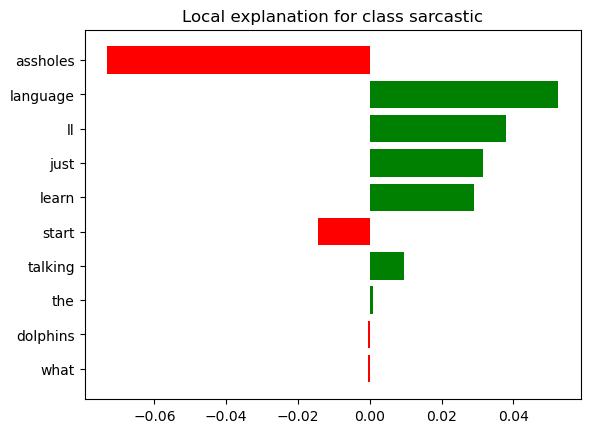

In [20]:
fig = lr_explanation.as_pyplot_figure()

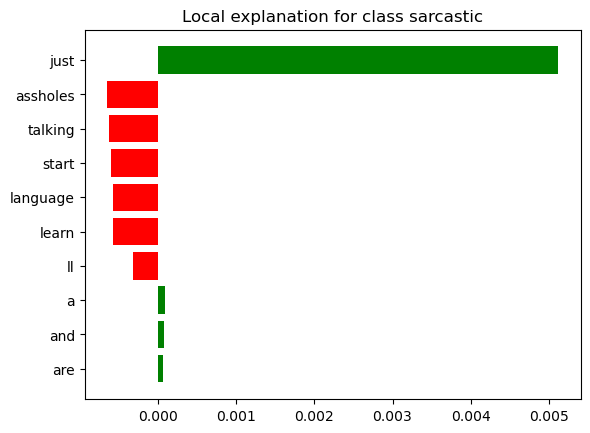

In [21]:
fig = rf_explanation.as_pyplot_figure()

Looks like the LogisticRegression model is finding multiple features. Both models seem to be picking up on "just" as a feature, which likely reflects its usage in trivializing/minimizing language, e.g., "it's _just_ a homework assignment," and probably correlates with sarcastic languauge (see [Kiesling (2011)](https://www.researchgate.net/profile/Scott_Kiesling2/publication/277710719_Stance_in_Context_Affect_alignment_and_investment_in_the_analysis_of_stancetaking/links/55708f0308aeec5e6fd263b0/Stance-in-Context-Affect-alignment-and-investment-in-the-analysis-of-stancetaking.pdf) if you want to learn more on the sociolinguistic uses of "just").

### Task 4.1.9:  Look at model confidence scores
Both models were not very confident in  their predictions (scores near the decision boundary of 0.5). As one final diagnosis, let's look at distribution of model confidences across the instances.

Create two lists, `rf_imb_probs` and `lr_imb_probs` to hold the probability values of each model's predictions on the imbalanced dataset.

In [22]:
lr_imb_probs = lr_pipeline.predict_proba(test_imb_df)[:, 1]
rf_imb_probs = rf_pipeline.predict_proba(test_imb_df)[:, 1]

Let's put these probabilities into a data frame so we can plot them cleanly with Seaborn 

In [23]:
df = { 'probability': [], 'model': []}
df['probability'].extend(rf_imb_probs)
df['model'].extend(['RandomForest'] * len(rf_imb_probs))
df['probability'].extend(lr_imb_probs)
df['model'].extend(['LogisticRegression'] * len(lr_imb_probs))
df = pd.DataFrame(df)
df.head()

,probability,model
0,0.491199,RandomForest
1,0.491199,RandomForest
2,0.408854,LogisticRegression
3,0.416591,LogisticRegression


We'll use a kde plot to make some nice looking curves to visualize the two models' distributions over confidence scores.

<AxesSubplot: xlabel='probability', ylabel='Density'>

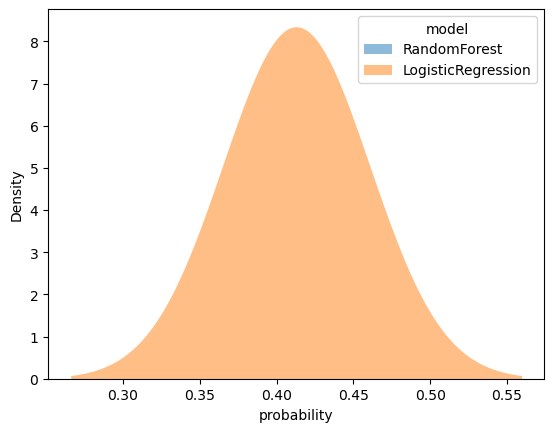

In [24]:
sns.kdeplot(
   data=df, x="probability", hue="model", 
   fill=True, common_norm=False,
   alpha=.5, linewidth=0, bw_adjust=10,
)

Interesting! The Logistic Regression model is slightly biased towards labeling item as sarcastic (note its mean is above 0.5), which is problematic in our imbalanced setting where sarcasm is much more rare. In contrast, the Random Forest model has its probabiliites centered closer to 0.5, suggesting it's never quite confident. If you see this in the real world, it could be a sign that you need to rebalance your training data so that models are biased towards the expected distribution of the classes.

# Next steps
This exercise has shown you another text classification problem for estimating whether a message is sarcastic using a massive real-world dataset. When using the simple models from before, the performance is much lower than when we tried to predict nationality! To dig into this a bit more, we've look at two classifiers, used Lime to explain what each is looking at, and examined their prediction distributions. These point to a few ways you can try exploring the data and models in next steps:

* Identify data points that the models are confident about and see if you agree with the features the model is looking at. How would you adjust the model accordingly?
* Try adjusting the hyperparameters of the models to see if you can improve performance. We've set the current values to ensure the script runs efficiently in the auto-grader, but you can increase the values in your own testing. The RandomForestClassifier has many potential options (e.g., using more trees, allowing for deeper trees) that may give you a more robust classifier.
* In Exercise 2.2, we used dense representations; given the short tests here, dense representations might be useful for learning across models.
* There are some words that seem more sarcastic than others. One idea is to create a lexicon of sarcastic words and add these as features.
* The training data is balanced, which is often useful for training a classifier. However, since we might way to apply this in a real setting where sarcasm is rare, one idea is to _rebalance_ the training data to remove some instance (also known as undersampling) to improve performance.
* Another option instead of undersampling is to tell the model to penalize some mistakes more than others. Sklearn supports this with its `class_weight` argument. You could try to increase the class weight to make the model more or less conservative for labeling an instance as sarcastic.